### Perceptual Control Theory
According to Henry Yin & William Powers, Control Theory ought to be about stabilizing a control variable (**q**) derived from an input from the environment (**v**),  rather than the behavior output itself (**o**). In the Perceptual Control Theory formulation, an agent's behavior is an output to a system (), which then gets turned into an input quantity via disturbance (**d**) and environmental feedback (**o -> v**) functions. The input is then compared against a goal reference quantity (**q***), revealing how "off" (error) the output behavior was in generating the desired state. 

In our paradigm, agents generate a behavior in order to push another agent towards their reference point (predicted behavior). At the same time, they are updating their predictions to match the input behaviors of others. Given some error between the reference signal and the input sensor signal, the effector function (**f(error)=$\Delta q$** i.e. update the function seeking to approximate the environmental feedback function) converts this error into an updated output behavior that is predicted to produce an input closer to the reference signal. The other agent is in this case the noisy environment, returning a commensurate set of behaviors. These will differ from the reference signal to a less degree (given an accurate update), and the loop continues. 

---

**Social Control Paradigm**

Output: my behavior

Input:  your behavior

Internal reference: my prediction

Goal: create two updates to explore dynamics
- learning to predict others (curious agent)
- updating output behaviors to shift behaviors towards reference prediction (coercive/conformist agent)





In [254]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as sp
import itertools as it
import math
import sys
sys.path.append('../')
from agents.agent import Agent
from agents.utils.utility import sigmoid_update #, linear_update
import seaborn as sns  
sns.set_style('darkgrid')

### Gradient Descent
A key task for the agent is going to be approximating how behavioral priors change given a new behavior. We can start by fixing a base prior that changes proportionally to error from a given behavior. Can we use gradient descent to see how much a prior changes given a behavior?

Next we make the other agents' predictions change between time steps so error is harder to infer. 

Then finally, we allow priors to shift as well.

In [255]:
# objective function
def get_prior(prior, error, slope):
    new_prior = prior + error*slope
    if new_prior > 1:
        return 1
    if new_prior < 0:
        return 0
    return new_prior

# behavior generator
def get_behavior(prior):
    return np.random.binomial(1, prior)

In [466]:
x_vals = np.random.uniform(-1, 1, 2)
x  = np.tile(x_vals,(2,1))
print(x)

[[ 0.25513549 -0.57470706]
 [ 0.25513549 -0.57470706]]


In [464]:
x_vals = np.random.uniform(-1, 1, 3)
dim_0 = np.ones(x_vals.shape[0])
x = np.c_[dim_0, x_vals]
x  = np.tile(x,(2,1,1))
print(x)

[[[ 1.          0.76778426]
  [ 1.         -0.86436812]
  [ 1.          0.21781767]]

 [[ 1.          0.76778426]
  [ 1.         -0.86436812]
  [ 1.          0.21781767]]]


In [452]:
# example base prior (prior given no error) and slope (how priors change given error)
prior = 0.3
slope = 0.2
# number of trials  at each error
t = 25

x_vals = np.arange(-1, 1.01, 0.1)
dim_0 = np.ones(x_vals.shape[0])
x = np.c_[dim_0, x_vals]
p = [get_prior(prior, e, slope) for e in x.T[1]]
y = []
# run t trials for each level of error
for i in range(len(p)):
    trial = []
    for trials in range(t):
        trial.append(get_behavior(p[i]))
    trial_sum = sum(trial)
    y.append(trial_sum/t)

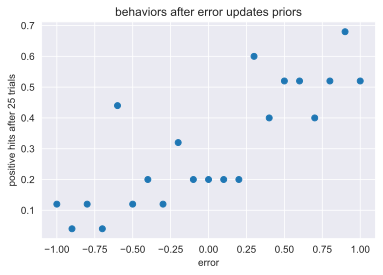

In [257]:
plt.scatter(x.T[1], y)
plt.xlabel('error')
plt.ylabel(f'probability of a positive hit')
plt.title('behaviors after error updates priors')
plt.show()

In [258]:

def grad_desc(x, y, rate = 0.1, iterations = 100):
    w = np.ones(x.shape[1])
    for _ in range(iterations):
        hypothesis = np.dot(x, w)
        #errors = y - x*w
        loss = hypothesis - y
        grad = np.dot(x.T, loss) / x.shape[0]
        #grad = -x * errors
        w = w - grad*rate
    return w

estimated base prior: 0.7168530857142859, estimated slope of change in prior: 0.873791310360809
true base prior: 0.3, true slope of change in prior: 0.2


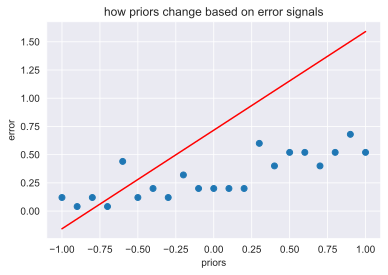

In [260]:
w = grad_desc(x,y,iterations=5)
prediction_y = [x.T[1][i]*w[1] + w[0] for i in range(x.shape[0])]
#prediction_y = x*w

plt.plot([x.T[1][0], x.T[1][-1]], [prediction_y[0],prediction_y[-1]], color="red")
plt.scatter(x.T[1], y)
plt.title("how priors change based on error signals")
plt.xlabel("error")
plt.ylabel("prior")
print(f"estimated base prior: {w[0]}, estimated slope of change in prior: {w[1]}")
print(f"true base prior: {prior}, true slope of change in prior: {slope}")

estimated base prior: 0.5496576642977145, estimated slope of change in prior: 0.7690851587162535
true base prior: 0.3, true slope of change in prior: 0.2


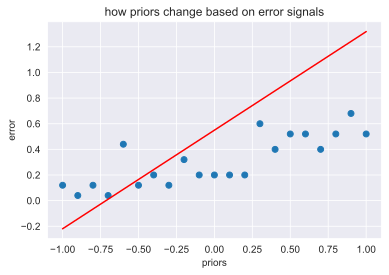

In [261]:
w = grad_desc(x,y,iterations=10)
prediction_y = [x.T[1][i]*w[1] + w[0] for i in range(x.shape[0])]
#prediction_y = x*w

plt.plot([x.T[1][0], x.T[1][-1]], [prediction_y[0],prediction_y[-1]], color="red")
plt.scatter(x.T[1], y)
plt.title("how priors change based on error signals")
plt.xlabel("error")
plt.ylabel("prior")
print(f"estimated base prior: {w[0]}, estimated slope of change in prior: {w[1]}")
print(f"true base prior: {prior}, true slope of change in prior: {slope}")


estimated base prior: 0.31213489600049005, estimated slope of change in prior: 0.37364506057754937
true base prior: 0.3, true slope of change in prior: 0.2


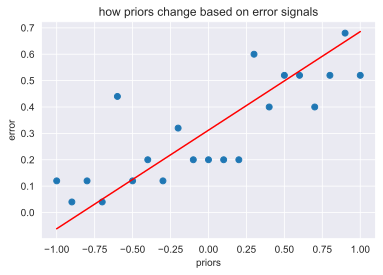

In [262]:
w = grad_desc(x,y,iterations=50)
prediction_y = [x.T[1][i]*w[1] + w[0] for i in range(x.shape[0])]
#prediction_y = x*w

plt.plot([x.T[1][0], x.T[1][-1]], [prediction_y[0],prediction_y[-1]], color="red")
plt.scatter(x.T[1], y)
plt.title("how priors change based on error signals")
plt.xlabel("error")
plt.ylabel("prior")
print(f"estimated base prior: {w[0]}, estimated slope of change in prior: {w[1]}")
print(f"true base prior: {prior}, true slope of change in prior: {slope}")

### No Direct Error Access
Given an accurate read of the error, we can estimate both the parameters required to model the behavior of the other agent. That is, change of prior given the error and the base prior (prior given error = 0). In reality, the agents must infer the error signal of the other agent in order to gauge the change in their behavior. This is done by mapping a behavior to a new prior. $$f(behavior_{t-1}) = p(behavior_t)$$

In [387]:
# let's assume they have a perfect estimate of our prior
their_prediction = my_prior = 0.2
their_prior = 0.4
their_slope = 0.2


# let's collect data on their behavior given ours
errors = np.array([])
behaviors = np.array([])
observations = np.array([])
time = 50
for t in range(time):
    my_behavior = get_behavior(my_prior)
    behaviors = np.append(behaviors, my_behavior)
    error = my_behavior - my_prior # I'm infering that my_prior = their_prediction
    errors = np.append(errors, error)
    their_new_prior = get_prior(their_prior, error, their_slope)
    their_behavior = get_behavior(their_new_prior)
    observations = np.append(observations, their_behavior)

my_output = np.array([0,1]).astype(float)
my_input = np.array([0,0]).astype(float)
for i in range(len(observations)):
    if behaviors[i]:
        my_input[1] += observations[i]
    else:
        my_input[0] += observations[i]
my_input[1] /= sum(behaviors)
my_input[0] /= (len(behaviors) - sum(behaviors))
overall_prior_estimate = sum(observations)/len(observations)
print(f"my estimate of their prior when my behavior is {my_output[0]}: {my_input[0]}")
print(f"my estimate of their prior when my behavior is {my_output[1]}: {my_input[1]}")
        

my estimate of their prior when my behavior is 0.0: 0.23684210526315788
my estimate of their prior when my behavior is 1.0: 0.6666666666666666


Text(0, 0.5, 'my behavior')

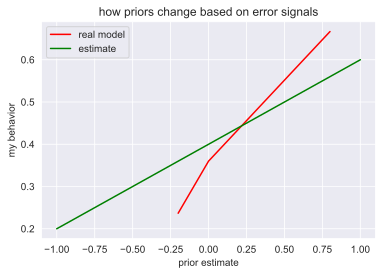

In [388]:
plt.plot([-0.2, 0, 0.8], [my_input[0], overall, my_input[1]], color="red", label="real model")
plt.plot([-1, 1], [0.2, 0.6], color="green", label="estimate")
plt.legend()
plt.title("how priors change based on error signals")
plt.xlabel("prior estimate")
plt.ylabel("my behavior")

In [426]:
# let's assume they have a perfect estimate of our prior
their_prediction = my_prior = 0.2
their_prior = 0.4
their_slope = -0.2


# let's collect data on their behavior given ours
errors = np.array([])
behaviors = np.array([])
observations = np.array([])
time = 50
for t in range(time):
    my_behavior = get_behavior(my_prior)
    behaviors = np.append(behaviors, my_behavior)
    error = my_behavior - my_prior # I'm infering that my_prior = their_prediction
    errors = np.append(errors, error)
    their_new_prior = get_prior(their_prior, error, their_slope)
    their_behavior = get_behavior(their_new_prior)
    observations = np.append(observations, their_behavior)

my_output = np.array([0,1]).astype(float)
my_input = np.array([0,0]).astype(float)
for i in range(len(observations)):
    if behaviors[i]:
        my_input[1] += observations[i]
    else:
        my_input[0] += observations[i]
my_input[1] /= sum(behaviors)
my_input[0] /= (len(behaviors) - sum(behaviors))
overall_prior_estimate = sum(observations)/len(observations)
print(f"my estimate of their prior when my behavior is {my_output[0]}: {my_input[0]}")
print(f"my estimate of their prior when my behavior is {my_output[1]}: {my_input[1]}")
        

my estimate of their prior when my behavior is 0.0: 0.38095238095238093
my estimate of their prior when my behavior is 1.0: 0.125


Text(0, 0.5, 'my behavior')

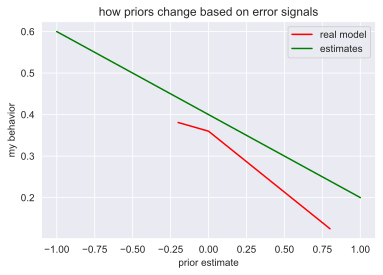

In [427]:
plt.plot([-0.2, 0, 0.8], [my_input[0], overall, my_input[1]], color="red", label="real model")
plt.plot([-1, 1], [get_prior(their_prior,-1,their_slope), get_prior(their_prior,1,their_slope)], color="green",  label="estimates")
plt.legend()
plt.title("how priors change based on error signals")
plt.xlabel("prior estimate")
plt.ylabel("my behavior")

### Dynamical System
What if priors do not remain anchored to a stable point?

In [493]:
# let's assume they have a perfect estimate of our prior
their_prediction = my_prior = 0.8
their_prior = 0.4
their_slope = -0.2


# let's collect data on their behavior given ours
errors = np.array([])
behaviors = np.array([])
observations = np.array([])
time = 2500
for t in range(time):
    my_behavior = get_behavior(my_prior)
    behaviors = np.append(behaviors, my_behavior)
    error = my_behavior - my_prior # I'm infering that my_prior = their_prediction
    errors = np.append(errors, error)
    their_prior = get_prior(their_prior, error, their_slope)
    their_behavior = get_behavior(their_prior)
    observations = np.append(observations, their_behavior)

my_output = np.array([0,1]).astype(float)
my_input = np.array([0,0]).astype(float)
for i in range(len(observations)):
    if behaviors[i]:
        my_input[1] += observations[i]
    else:
        my_input[0] += observations[i]
my_input[1] /= sum(behaviors)
my_input[0] /= (len(behaviors) - sum(behaviors))
overall_prior_estimate = sum(observations)/len(observations)
print(f"my estimate of their prior when my behavior is {my_output[0]}: {my_input[0]}")
print(f"my estimate of their prior when my behavior is {my_output[1]}: {my_input[1]}")
print(f"their  prior: {their_prior}")
        

my estimate of their prior when my behavior is 0.0: 0.6233269598470363
my estimate of their prior when my behavior is 1.0: 0.464339908952959
their  prior: 0.6400000000000013


Text(0, 0.5, 'my behavior')

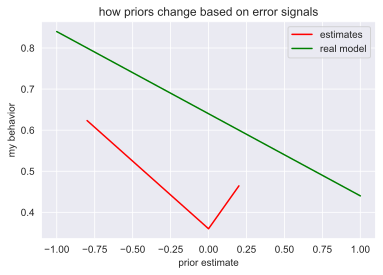

In [494]:
plt.plot([-my_prior, 0, 1-my_prior], [my_input[0], overall, my_input[1]], color="red", label="estimates")
#plt.plot([-1, 0, 1], [my_input[0], overall, my_input[1]], color="red", label="estimates")
plt.plot([-1, 1], [get_prior(their_prior,-1,their_slope), get_prior(their_prior,1,their_slope)], color="green",  label="real model")
plt.legend()
plt.title("how priors change based on error signals")
plt.xlabel("prior estimate")
plt.ylabel("my behavior")

### Stable Reference Signal
In this next experiment, let's assume the agent will not update its prediction, but have a stable reference signal that it will try to force the other agent into.

In [ ]:
# reference signal or stable prediction of the other agent
ref = 0.7


Text(0, 0.5, 'prior')

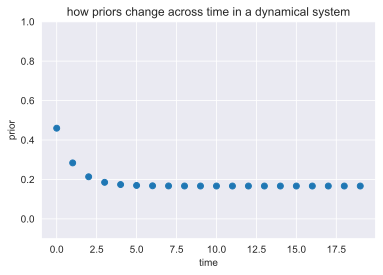